### Plot main results:  
    - heatmap of information as function of model parameters (horiz/ama weight vs center/surround weight)  
    - where ganglion cells map onto this heatmap
    - cumulative information of full model, horizontal, amacrine only models, ganglion cell, ideal filter, center vs frequency
    - total information vs SNR

In [18]:
import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

### Receptive fields of ganglion, bipolar, amacrine, and horizontal cells

In [3]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells()
cells['bipolar'] = load_bipolar_cells()
cells['amacrine'] = load_amacrine_cells()
cells['horizontal'] = load_horizontal_cells()

Verify that spacings for all cells is the same

In [4]:
spacings = []
for c in cells.keys():
    print(c)
    for space, rf in cells[c]:
        spacings.append(space)
samplerates = [float('%0.6f' %np.mean(np.diff(s))) for s in spacings]
print(np.unique(samplerates))

amacrine
bipolar
horizontal
ganglion
[ 0.444444  0.546835]


There are 2 different types of spacing. Let's take the average.

In [5]:
average_spacing = np.mean(np.stack([s for s in spacings if len(s)==80]), axis=0)
average_spacing -= np.min(abs(average_spacing)) # sample the peak at 0
average_spacing.shape

(80,)

In [6]:
np.mean(np.diff(average_spacing))

0.54683544303797449

Interpolate all of the receptive fields to be at the same spacing

In [7]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for space, rf in cells[c]:
        this_cell_interp = interp1d(space, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(average_spacing))

### Projective fields of amacrine and horizontal cells

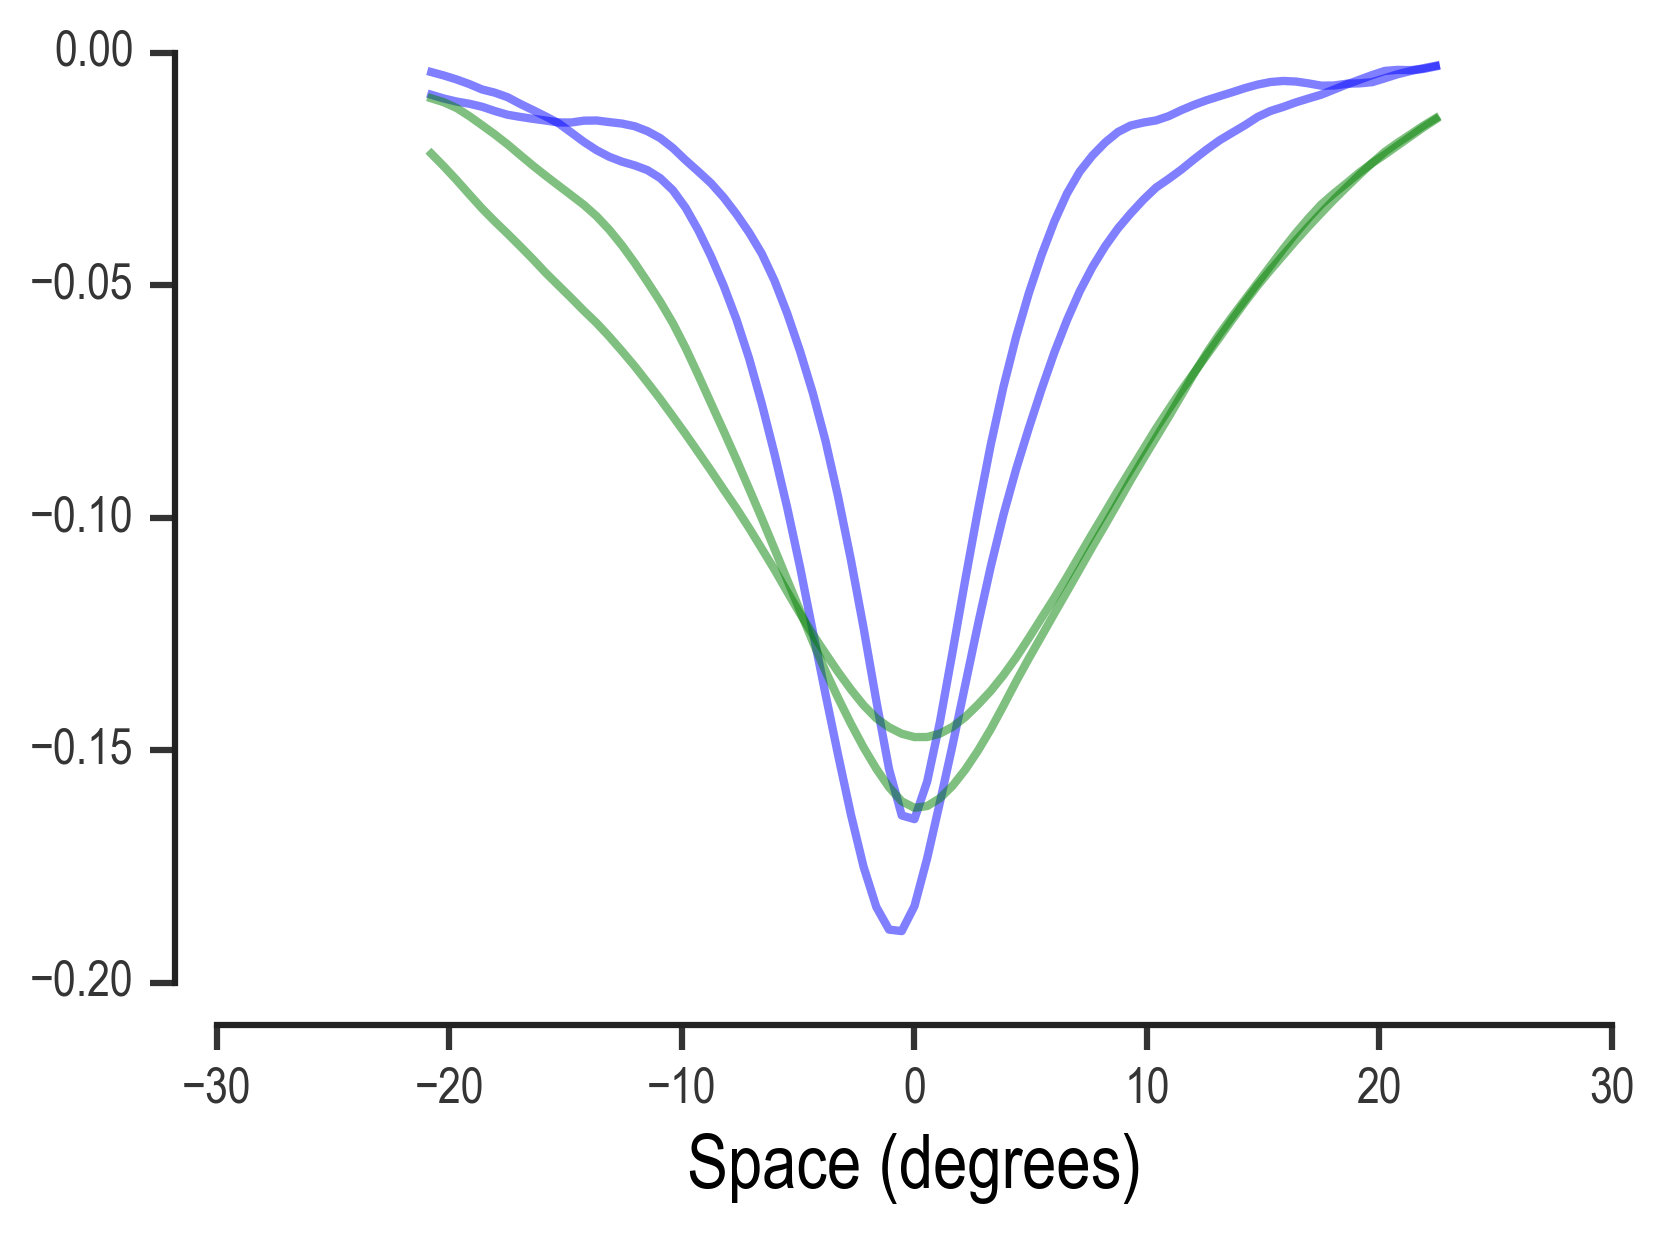

In [8]:
space_constants = {'horizontal': 118./22., 'amacrine': 78./22.}

projective_fields = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    if celltype in ['horizontal', 'amacrine']:
        for rf in receptive_fields[celltype]:
            spatial_smoothing = [np.exp(-abs(t)/space_constants[celltype]) for t in np.linspace(np.min(average_spacing),
                                                                                                np.max(average_spacing),
                                                                                                len(average_spacing))]
            proj_field = np.convolve(spatial_smoothing, rf, mode='same')
            proj_field *= np.mean(rf) / np.mean(proj_field)
            projective_fields[celltype].append(proj_field)

colorscheme = 'bg'
for i,celltype in enumerate(sorted(projective_fields.keys())):
    this_color = colorscheme[i]
    for pf in projective_fields[celltype]:
        plt.plot(average_spacing, pf, color=this_color, alpha=0.5, linewidth=2)
plt.xlabel('Space (degrees)', fontsize=18)
adjust_spines(plt.gca())

### Signal

Get the frequency range for average_spacing

In [79]:
freqs = np.linspace(0, 0.5/np.mean(np.diff(average_spacing)), len(np.fft.rfft(average_spacing)))
# if we're going to convolve the signal with a filter, we have to take into account the new convolution length
freqs_padded = np.linspace(0, 0.5/np.mean(np.diff(average_spacing)), 
                           len(np.fft.rfft(average_spacing, n=len(average_spacing)*2 - 1)))

In [10]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/data/images/Tkacik/cd01A'
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 70 files in directory.


In [12]:
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches, spacing=spacing)

Interpolate signal at same resolution and scale as cell measurements

In [82]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt_signal, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt_signal)
signal = func(freqs, *popt_signal)
signal_padded = func(freqs_padded, *popt_signal)
signal[0] = signal_amps[0]
signal_padded[0] = signal_amps[0]

[ 0.0056951   1.01550079]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


### Difference of Gaussians

In [63]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0.)

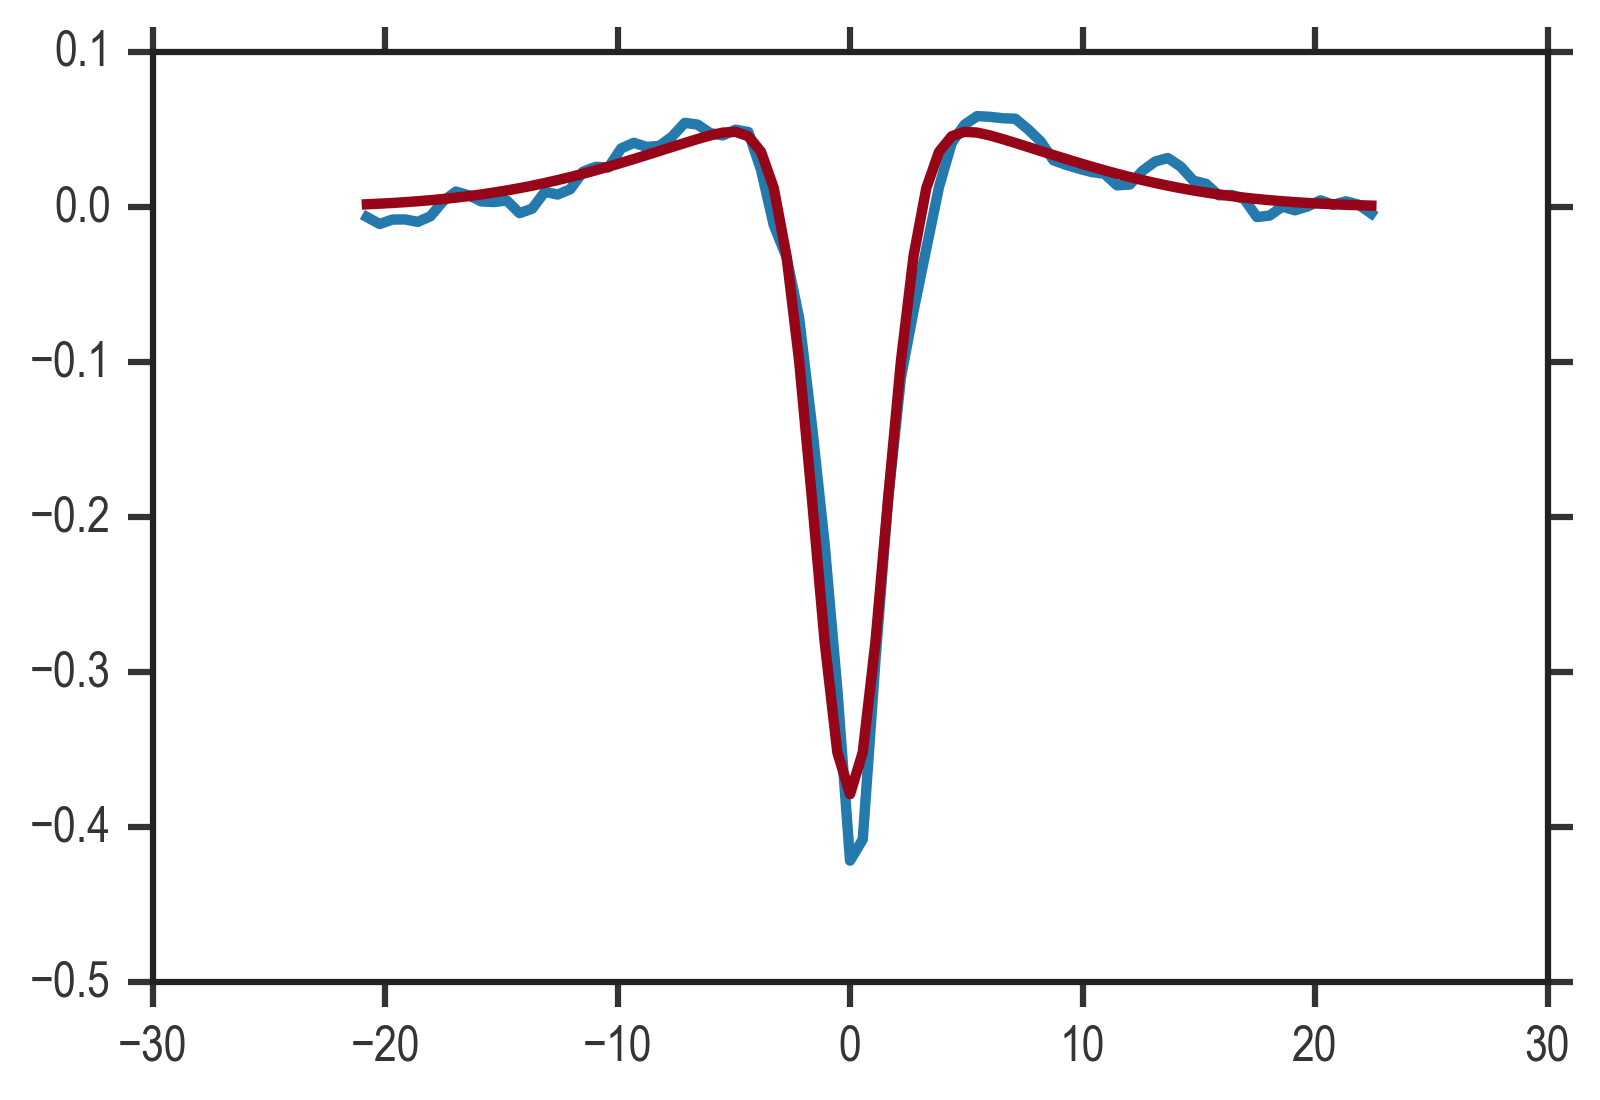

In [70]:
average_ganglion = np.mean(np.stack(receptive_fields['ganglion']), axis=0)
popt, pcov = curve_fit(diff_of_gauss_mu0, average_spacing, average_ganglion)
plt.plot(average_spacing, average_ganglion)
plt.plot(average_spacing, diff_of_gauss_mu0(average_spacing, *popt))

In [72]:
popt

array([ -1.53279508,   7.90997606,  -6.50747292,  24.45198112])

In [71]:
mean_center_width = abs(np.min(popt[:2]))

### Noise

In [16]:
input_noise = 0.12
output_noise = 0.35

### Compare ideal filter to different resolution signals

In [28]:
freqs_highres = np.linspace(0, freqs[-1], 1000)
signal_highres = func(freqs_highres, *popt_signal)
signal_highres[0] = signal[0]

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


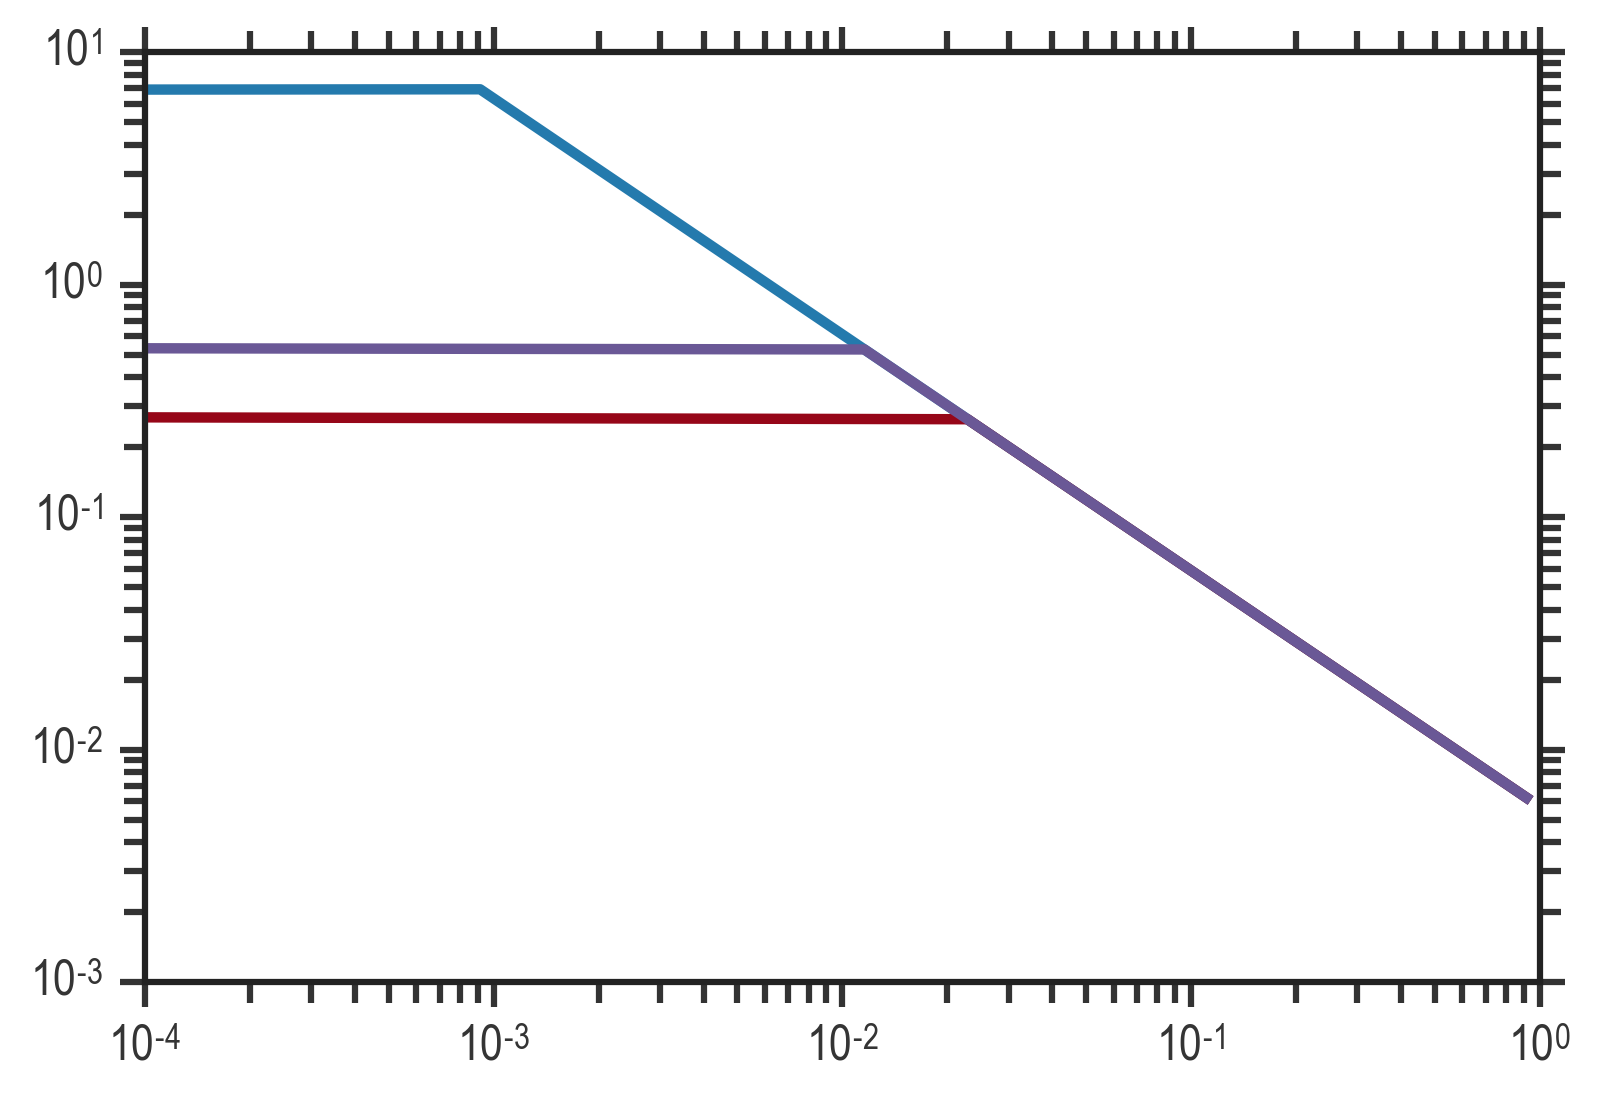

In [83]:
plt.plot(freqs_highres, signal_highres)
plt.plot(freqs, signal)
plt.plot(freqs_padded, signal_padded)
plt.xscale('log')
plt.yscale('log')

In [31]:
ideal_filt = unique_soln(signal**2, input_noise, output_noise)
ideal_filt_highres = unique_soln(signal_highres**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 1.66542878027e-07.
The relative error from this choice of Lagrangian multiplier is 3.69758020854e-07.


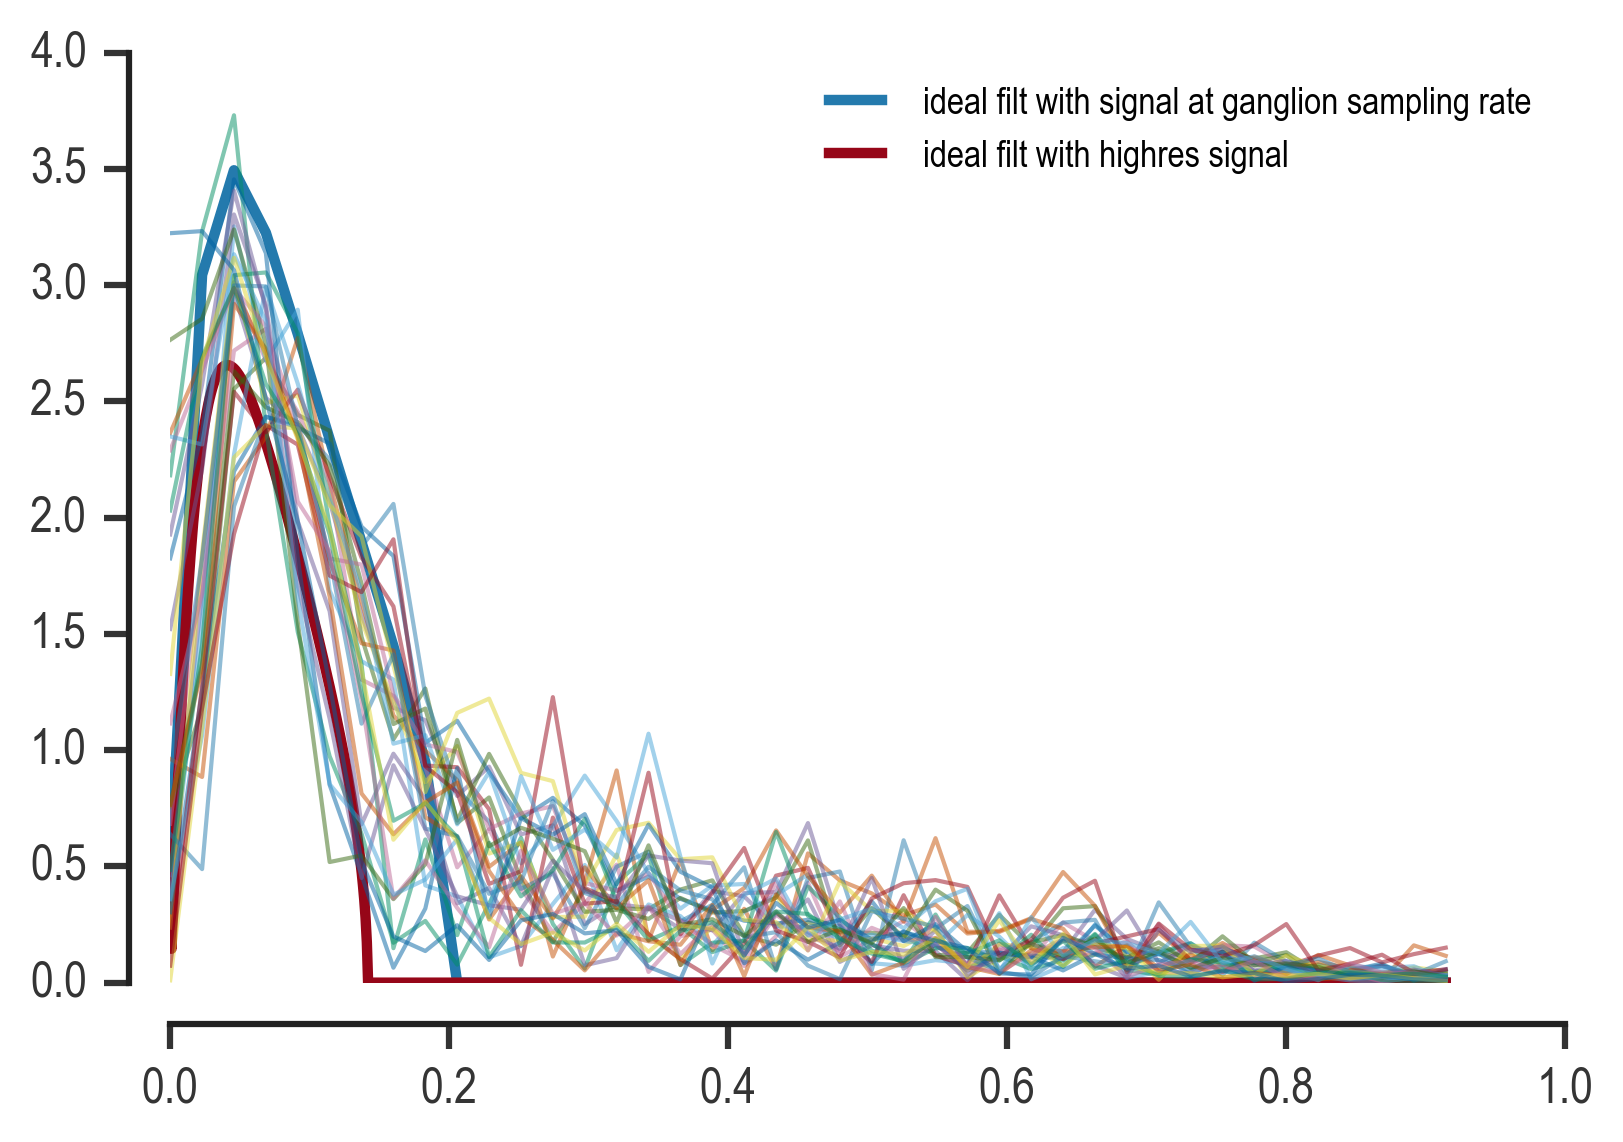

In [44]:
plt.plot(freqs, ideal_filt, label='ideal filt with signal at ganglion sampling rate')
plt.plot(freqs_highres, ideal_filt_highres, label='ideal filt with highres signal')
for g in receptive_fields['ganglion']:
    plt.plot(freqs, abs(np.fft.rfft(g)), linewidth=1, alpha=0.5)
plt.legend(frameon=False, fontsize=9)
adjust_spines(plt.gca())

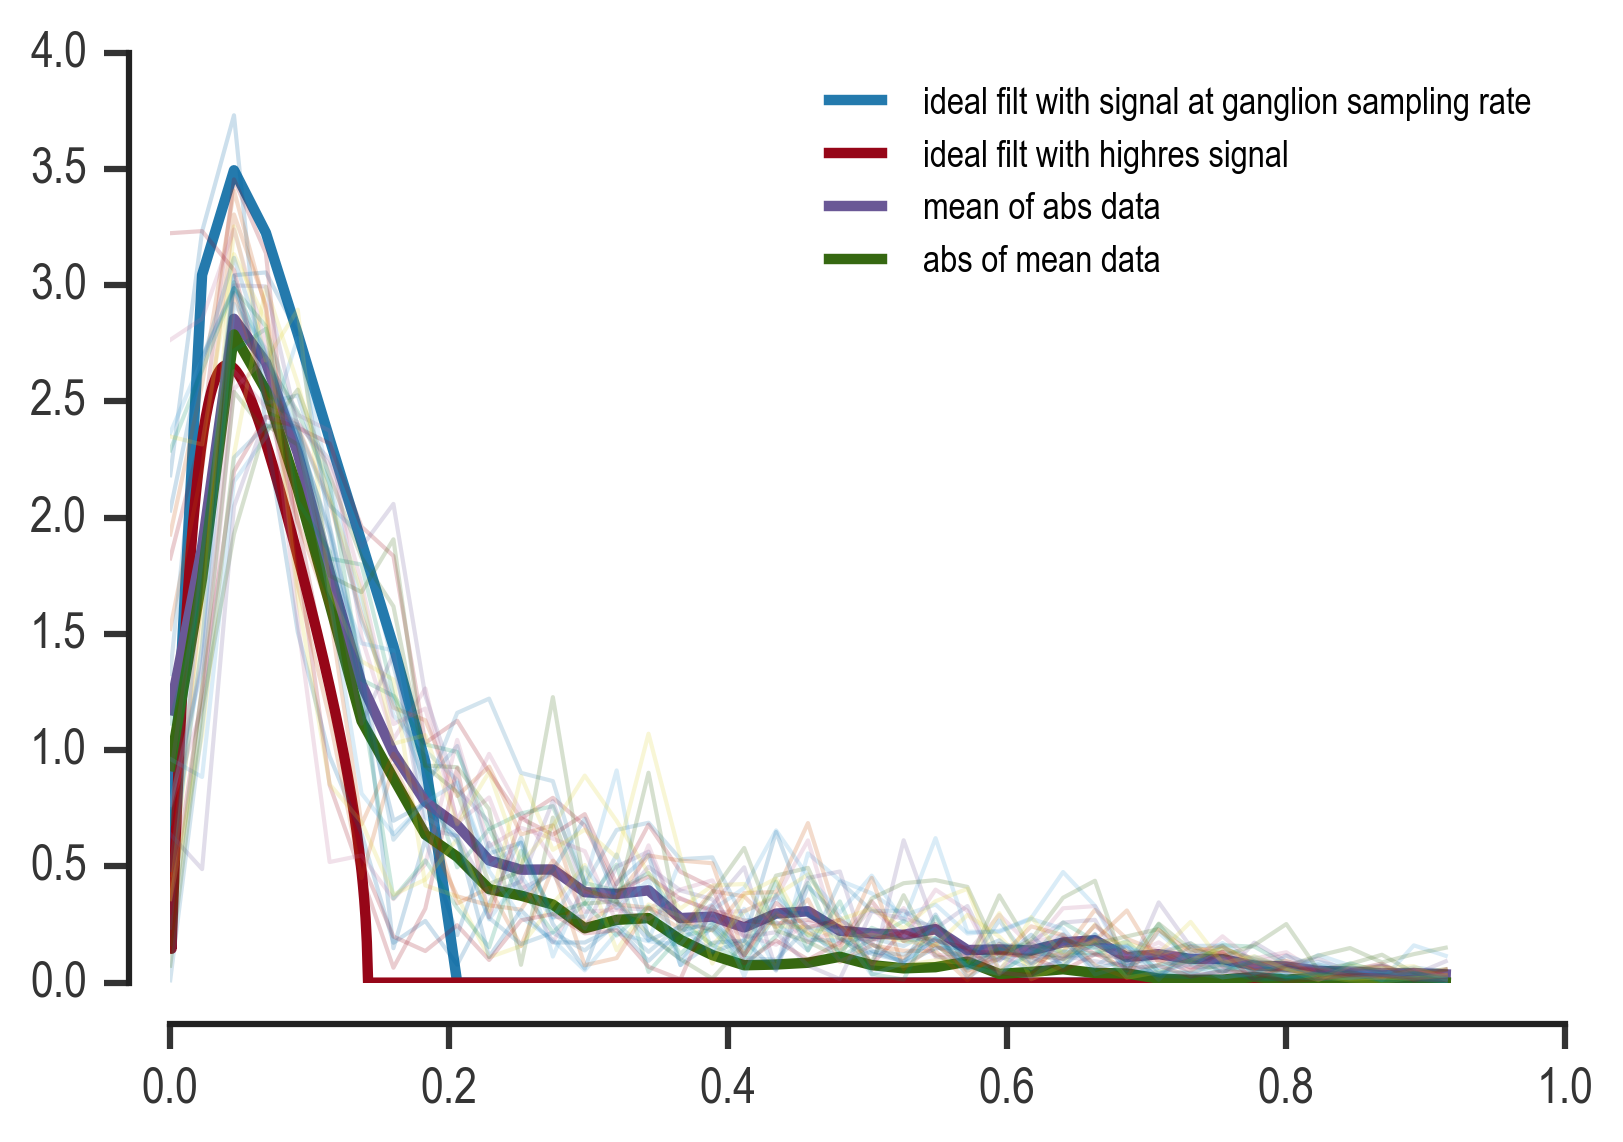

In [49]:
plt.plot(freqs, ideal_filt, label='ideal filt with signal at ganglion sampling rate')
plt.plot(freqs_highres, ideal_filt_highres, label='ideal filt with highres signal')
plt.plot(freqs, np.mean(np.stack([abs(np.fft.rfft(g)) for g in receptive_fields['ganglion']]), axis=0),
        label='mean of abs data')
plt.plot(freqs, abs(np.mean(np.stack([np.fft.rfft(g) for g in receptive_fields['ganglion']]), axis=0)),
        label='abs of mean data')

for g in receptive_fields['ganglion']:
    plt.plot(freqs, abs(np.fft.rfft(g)), linewidth=1, alpha=0.2)
plt.legend(frameon=False, fontsize=9)
adjust_spines(plt.gca())

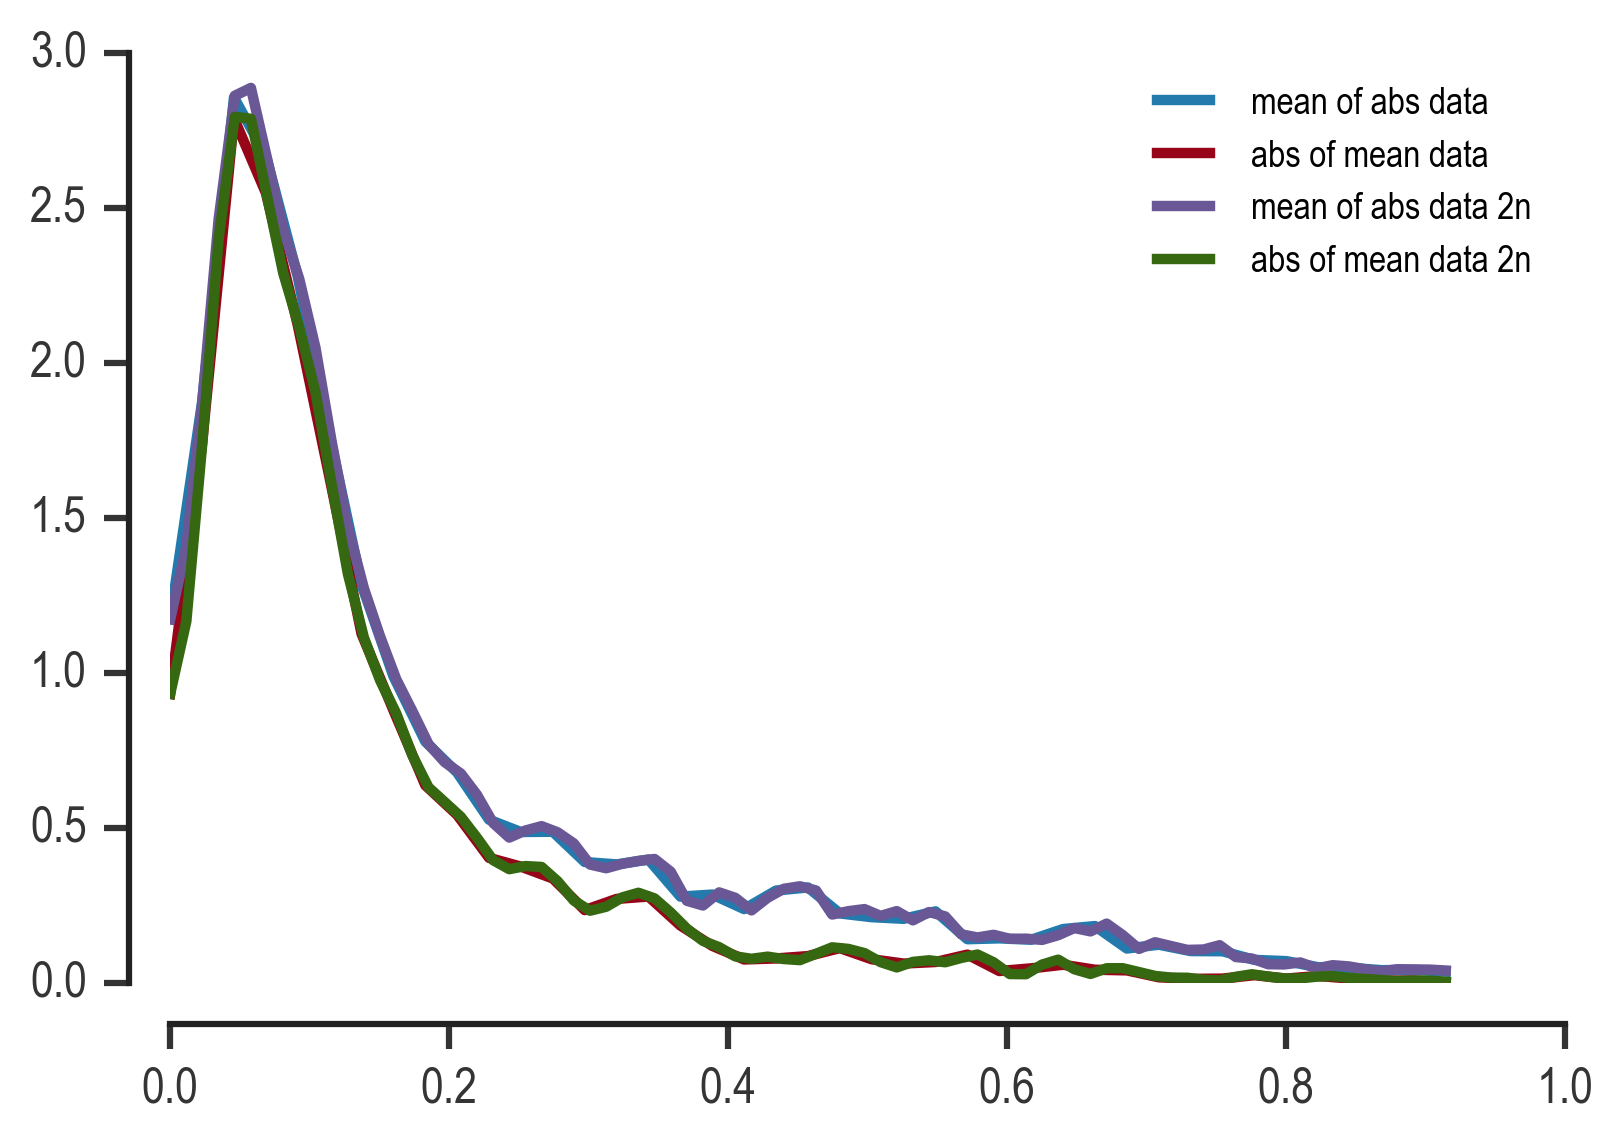

In [55]:
# plt.plot(freqs, ideal_filt, label='ideal filt with signal at ganglion sampling rate')
# plt.plot(freqs_highres, ideal_filt_highres, label='ideal filt with highres signal')
plt.plot(freqs, np.mean(np.stack([abs(np.fft.rfft(g)) for g in receptive_fields['ganglion']]), axis=0),
        label='mean of abs data')
plt.plot(freqs, abs(np.mean(np.stack([np.fft.rfft(g) for g in receptive_fields['ganglion']]), axis=0)),
        label='abs of mean data')
plt.plot(np.linspace(0, freqs[-1], 2*(len(freqs)-1)),
         np.mean(np.stack([abs(np.fft.rfft(g, n=2*len(g)-1)) for g in receptive_fields['ganglion']]), axis=0),
         label='mean of abs data 2n')
plt.plot(np.linspace(0, freqs[-1], 2*(len(freqs)-1)),
         abs(np.mean(np.stack([np.fft.rfft(g, n=2*len(g)-1) for g in receptive_fields['ganglion']]), axis=0)),
         label='abs of mean data 2n')
plt.legend(frameon=False, fontsize=9)
adjust_spines(plt.gca())

In [86]:
ganglion_padded = abs(np.mean(np.stack([np.fft.rfft(g, n=2*len(g)-1) for g in receptive_fields['ganglion']]), axis=0))

In [99]:
target_variance = 10
def constrain_filt_var(filt_const):
    filt_variance = get_output_var(input_noise, output_noise, signal_padded, filt_const*ganglion_padded)
    return (target_variance - filt_variance)**2

ganglion_filt_const_opt = scipy.optimize.minimize(constrain_filt_var, 0.4)
ganglion_filt_const = abs(ganglion_filt_const_opt['x'])

In [100]:
ganglion_filt_const_opt

      fun: 3.1512230495728068e-18
 hess_inv: array([[ 106741.33621221]])
      jac: array([ -1.85601572e-10])
  message: 'Optimization terminated successfully.'
     nfev: 48
      nit: 2
     njev: 16
   status: 0
  success: True
        x: array([ 258.17692703])

In [102]:
ganglion_padded_constrained = ganglion_filt_const * ganglion_padded

## Redo information calculation

Couldn't fit cell 15
Couldn't fit cell 21
Couldn't fit cell 27


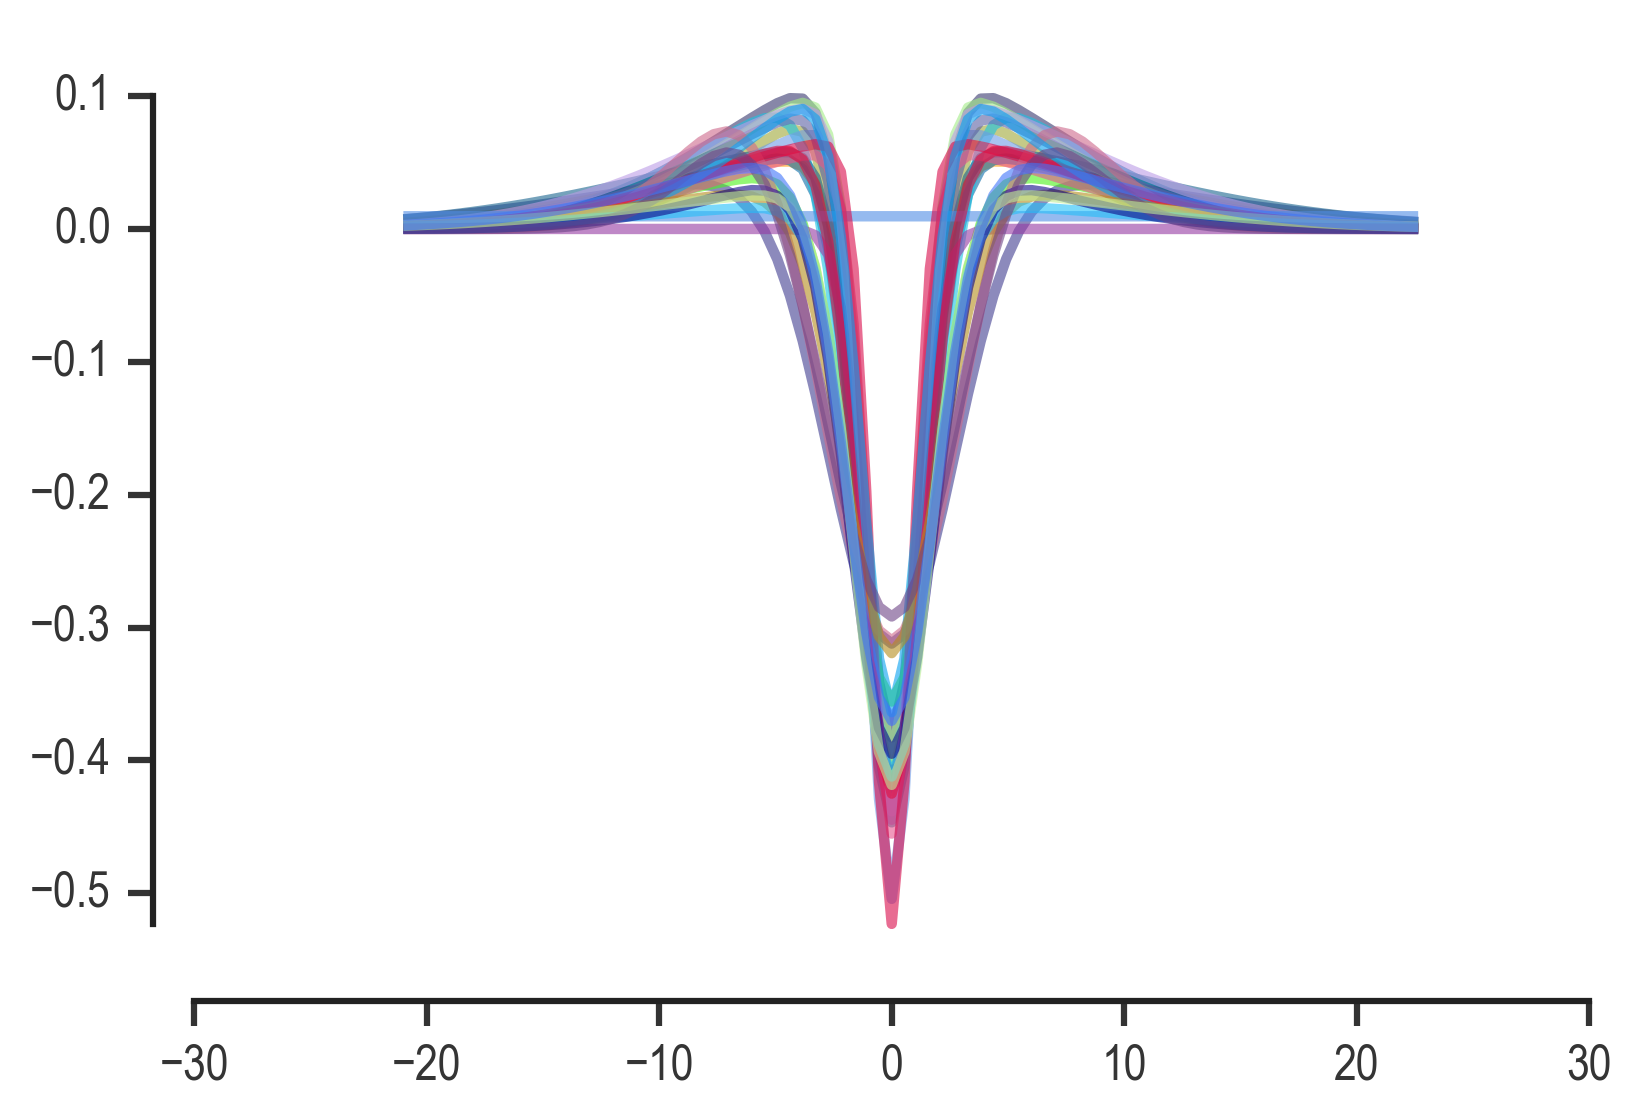

In [67]:
center_widths = []
surround_widths = []
for idg, g in enumerate(receptive_fields['ganglion']):
    try:
        popt_this, pcov = curve_fit(diff_of_gauss_mu0, average_spacing, g)
        center_widths.append(np.min(abs(popt_this[:2])))
        surround_widths.append(np.max(abs(popt_this[:2])))
        plt.plot(average_spacing, diff_of_gauss_mu0(average_spacing, *popt_this), color=np.random.rand(3), alpha=0.6)
    except:
        print("Couldn't fit cell %d" %idg)
        
plt.ylim(-.55, .15)
adjust_spines(plt.gca())

In [74]:
center_width = np.median(center_widths)
print(center_width)

1.4211101852


In [75]:
# Get original data
horz_pfs = get_horizontal_projective_field()
ama_pfs  = get_amacrine_projective_field()

# get means of the projective fields
space_h, horz_pf, horz_sem = get_mean(horz_pfs)
space_a, ama_pf, ama_sem   = get_mean(ama_pfs)

# interpolate horz and ama to get a unified space; mode='valid'
horz_interp = interp1d(space_h, horz_pf, kind='linear', bounds_error=False, fill_value='extrapolate')
ama_interp  = interp1d(space_a, ama_pf, kind='linear', bounds_error=False, fill_value='extrapolate')

# project interpolations on unified space
horz_pf     = horz_interp(average_spacing)
ama_pf      = ama_interp(average_spacing)

# make center
center = gaussian(x=average_spacing, sigma=center_width, mu=0.) # gaussian

In [77]:
def rf_cached(horz_weight, center_weight):
    horz_weight = np.min([1.0, abs(horz_weight)])
    center_weight = np.min([1.0, abs(center_weight)])
    return center_weight*center + (1 - center_weight)*(horz_weight*horz_pf + (1 - horz_weight)*ama_pf)

In [105]:
input_noises = [0.01, 0.12, 0.4]
info_colormaps_vs_noise_innersum = collections.defaultdict(list)
info_colormaps_vs_noise_outersum = collections.defaultdict(list)
mse_colormaps_vs_noise_ganglion = collections.defaultdict(list)
mse_colormaps_vs_noise_ideal = collections.defaultdict(list)
mse_colormaps_vs_noise_ideal_hr = collections.defaultdict(list)

resolution = 150
target_variance = 10
horz_weights = np.linspace(0.,1.,resolution)
center_weights = np.linspace(0.,1.,resolution)
init_filt_const = 0.4

for input_noise in input_noises:
    info_color_map_innersum = np.zeros((resolution, resolution))
    info_color_map_outersum = np.zeros((resolution, resolution))
    mse_color_map_ganglion = np.zeros((resolution, resolution))
    mse_color_map_ideal = np.zeros((resolution, resolution))
    mse_color_map_ideal_hr = np.zeros((resolution, resolution))
    
    ideal_filt = unique_soln(signal**2, input_noise, output_noise)
    ideal_filt_highres = unique_soln(signal_highres**2, input_noise, output_noise)
    
    def constrain_filt_var(filt_const):
        filt_variance = get_output_var(input_noise, output_noise, signal, filt_const*ideal_filt)
        return (target_variance - filt_variance)**2  
    ideal_filt_const_opt = scipy.optimize.minimize(constrain_filt_var, 0.4)
    ideal_filt_const = abs(ideal_filt_const_opt['x'])
    
    def constrain_filt_var(filt_const):
        filt_variance = get_output_var(input_noise, output_noise, signal_highres, filt_const*ideal_filt_highres)
        return (target_variance - filt_variance)**2
    ideal_filt_hr_const_opt = scipy.optimize.minimize(constrain_filt_var, 0.4)
    ideal_filt_hr_const = abs(ideal_filt_hr_const_opt['x'])
    
    ideal_filt_interp = interp1d(freqs, ideal_filt_const*ideal_filt, kind='slinear', 
                                 bounds_error=False, fill_value=[0])
    ideal_filt_hr_interp = interp1d(freqs_highres, ideal_filt_hr_const*ideal_filt_highres, kind='slinear',
                                   bounds_error=False, fill_value=[0])
    ideal = ideal_filt_interp(freqs_padded)
    ideal_hr = ideal_filt_hr_interp(freqs_padded)

    for idh,hw in tqdm(enumerate(horz_weights)):
        for idc,cw in enumerate(center_weights):
            rf_model = rf_cached(hw, cw)
            rf_filt = abs(np.fft.rfft(rf_model, n=2*len(rf_model)-1))

            def constrain_filt_var(filt_const):
                filt_variance = get_output_var(input_noise, output_noise, signal_padded, filt_const*rf_filt)
                return (target_variance - filt_variance)**2

            filt_const_opt = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
            filt_const = abs(filt_const_opt['x'])

            # compute total information for this particular model
            snr = get_snr(input_noise, output_noise, signal_padded, filt_const*rf_filt)
            signal_vars = get_signal_var(signal_padded, filt_const*rf_filt, total_var=False)
            noise_vars = get_noise_var(input_noise, output_noise, filt_const*rf_filt, total_var=False)
            info_color_map_innersum[idh,idc] = 0.5*np.log2(1 + snr)
            info_color_map_outersum[idh,idc] = 0.5*np.sum(np.log2(1 + signal_vars/noise_vars))
            
            # compute the MSE difference between this model filter and the ideal filter
            mse_color_map_ganglion[idh,idc] = np.mean((ganglion_padded_constrained - filt_const*rf_filt)**2)
            mse_color_map_ideal[idh,idc] = np.mean((ideal - filt_const*rf_filt)**2)
            mse_color_map_ideal_hr[idh,idc] = np.mean((ideal_hr - filt_const*rf_filt)**2)

#         if idh % 10 == 0:
#             print('On iteration %d/%d' %(idh*resolution, resolution*resolution))
            
    info_colormaps_vs_noise_innersum[input_noise] = info_color_map_innersum
    info_colormaps_vs_noise_outersum[input_noise] = info_color_map_outersum
    mse_colormaps_vs_noise_ganglion[input_noise] = mse_color_map_ganglion
    mse_colormaps_vs_noise_ideal[input_noise] = mse_color_map_ideal
    mse_colormaps_vs_noise_ideal_hr[input_noise] = mse_color_map_ideal_hr


The relative error from this choice of Lagrangian multiplier is 3.34672264259e-07.
The relative error from this choice of Lagrangian multiplier is 1.10855208407e-06.
The relative error from this choice of Lagrangian multiplier is 1.49156212842e-07.


The relative error from this choice of Lagrangian multiplier is 1.38251724728e-07.
The relative error from this choice of Lagrangian multiplier is 1.52168127011e-08.


The relative error from this choice of Lagrangian multiplier is 2.0561831499e-08.


In [108]:
info_colormaps_vs_noise_innersum.keys()

dict_keys([0.12, 0.4, 0.01])

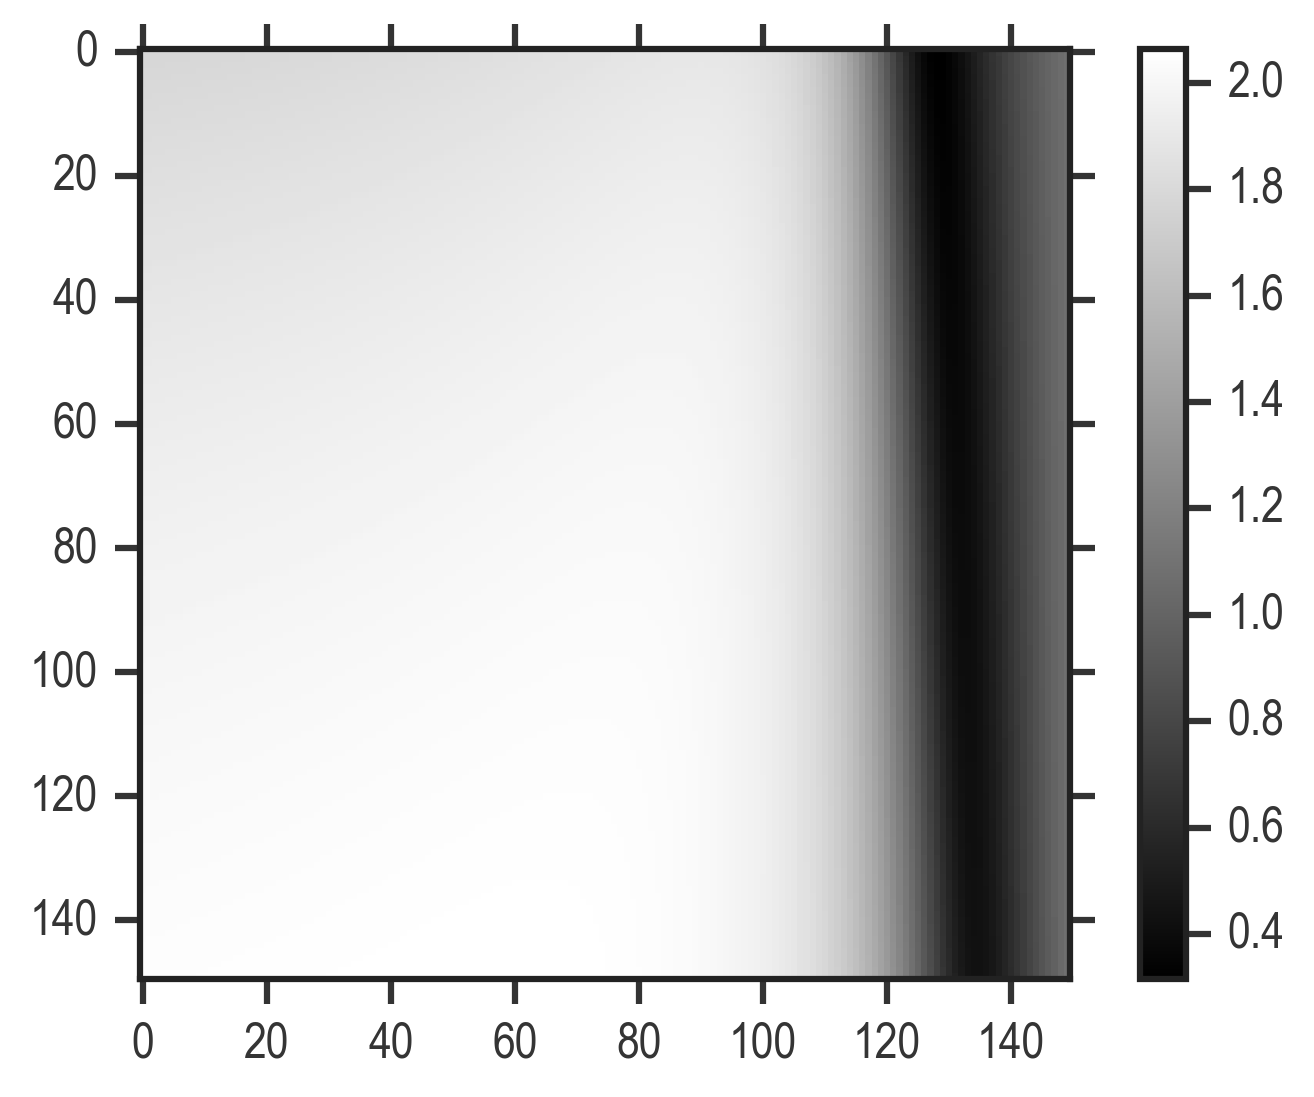

In [111]:
plt.imshow(info_colormaps_vs_noise_innersum[0.12])
plt.colorbar()

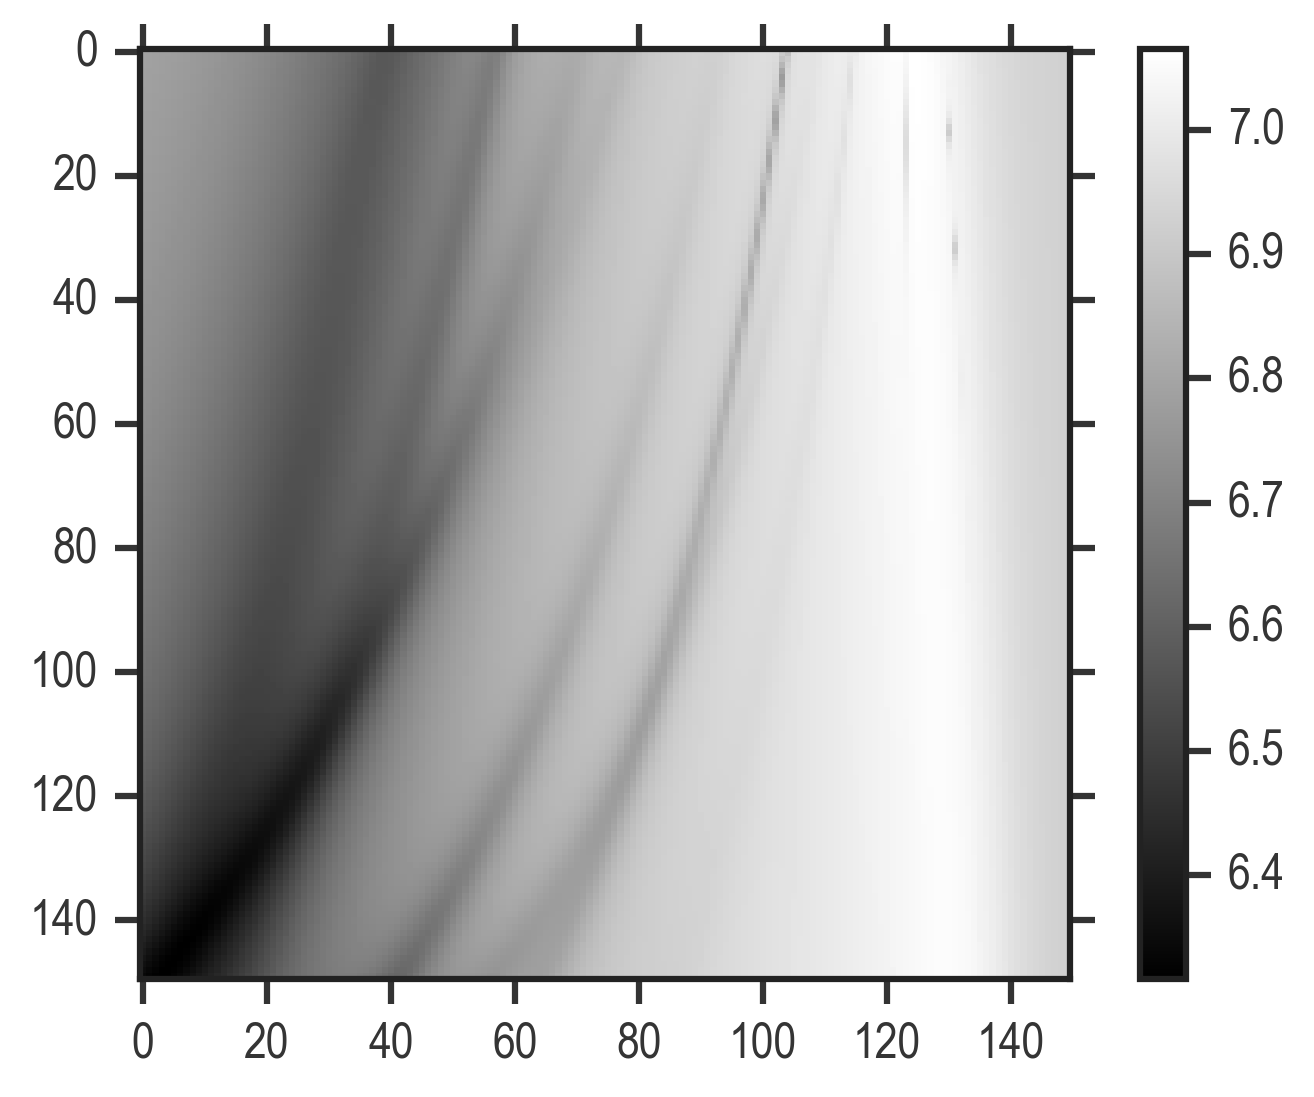

In [112]:
plt.imshow(info_colormaps_vs_noise_outersum[0.12])
plt.colorbar()

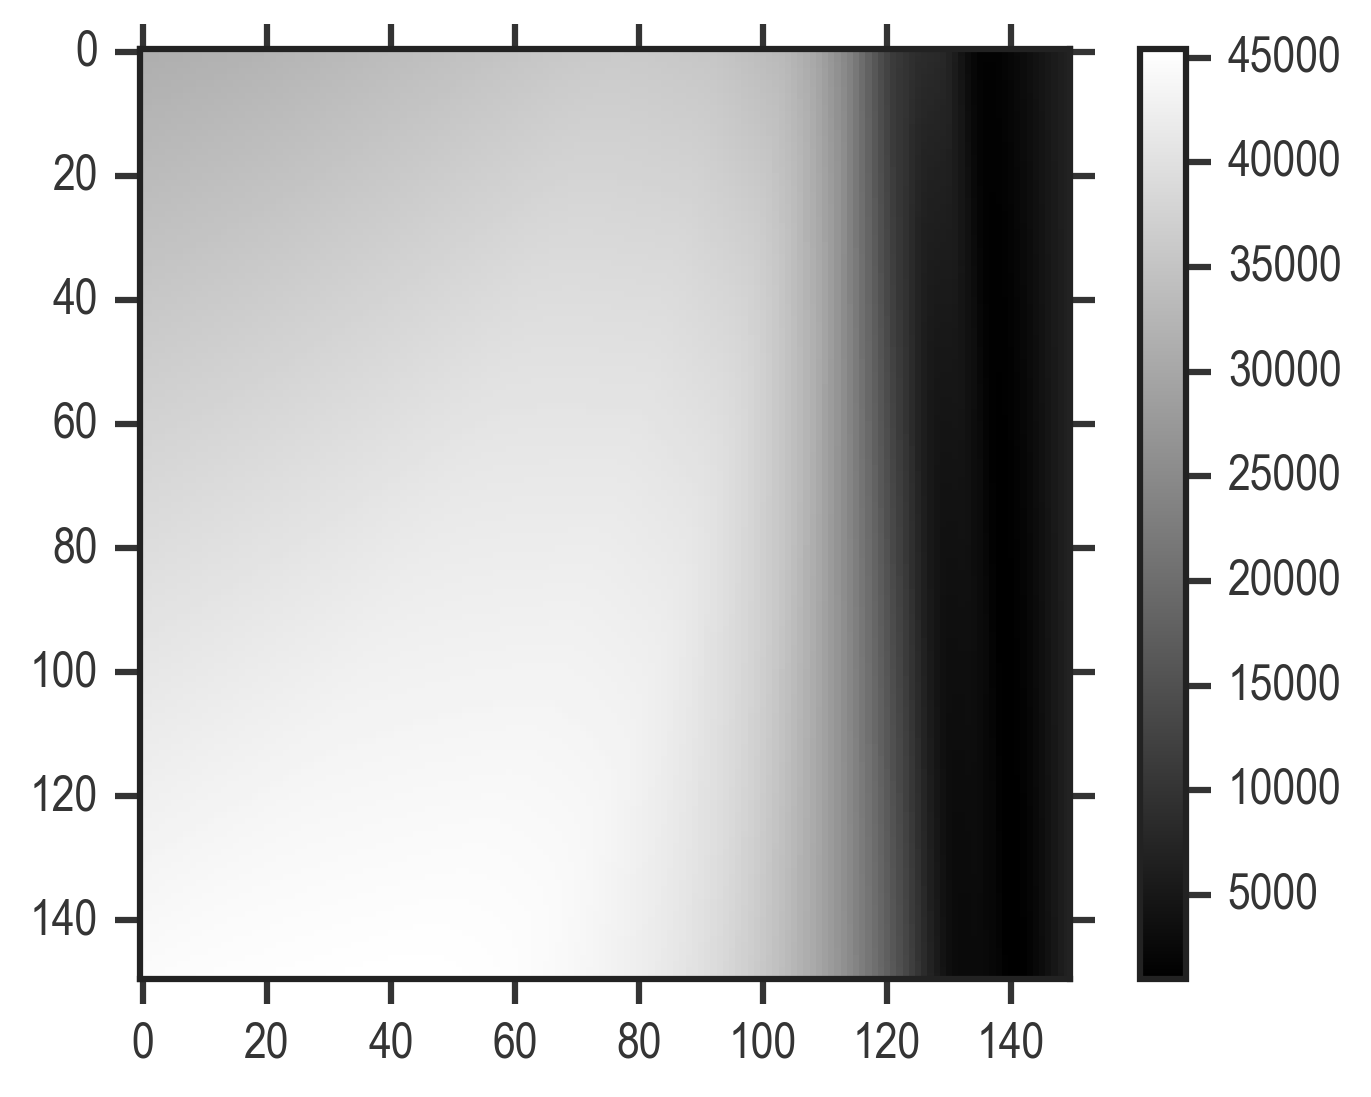

In [113]:
plt.imshow(mse_colormaps_vs_noise_ganglion[0.12])
plt.colorbar()

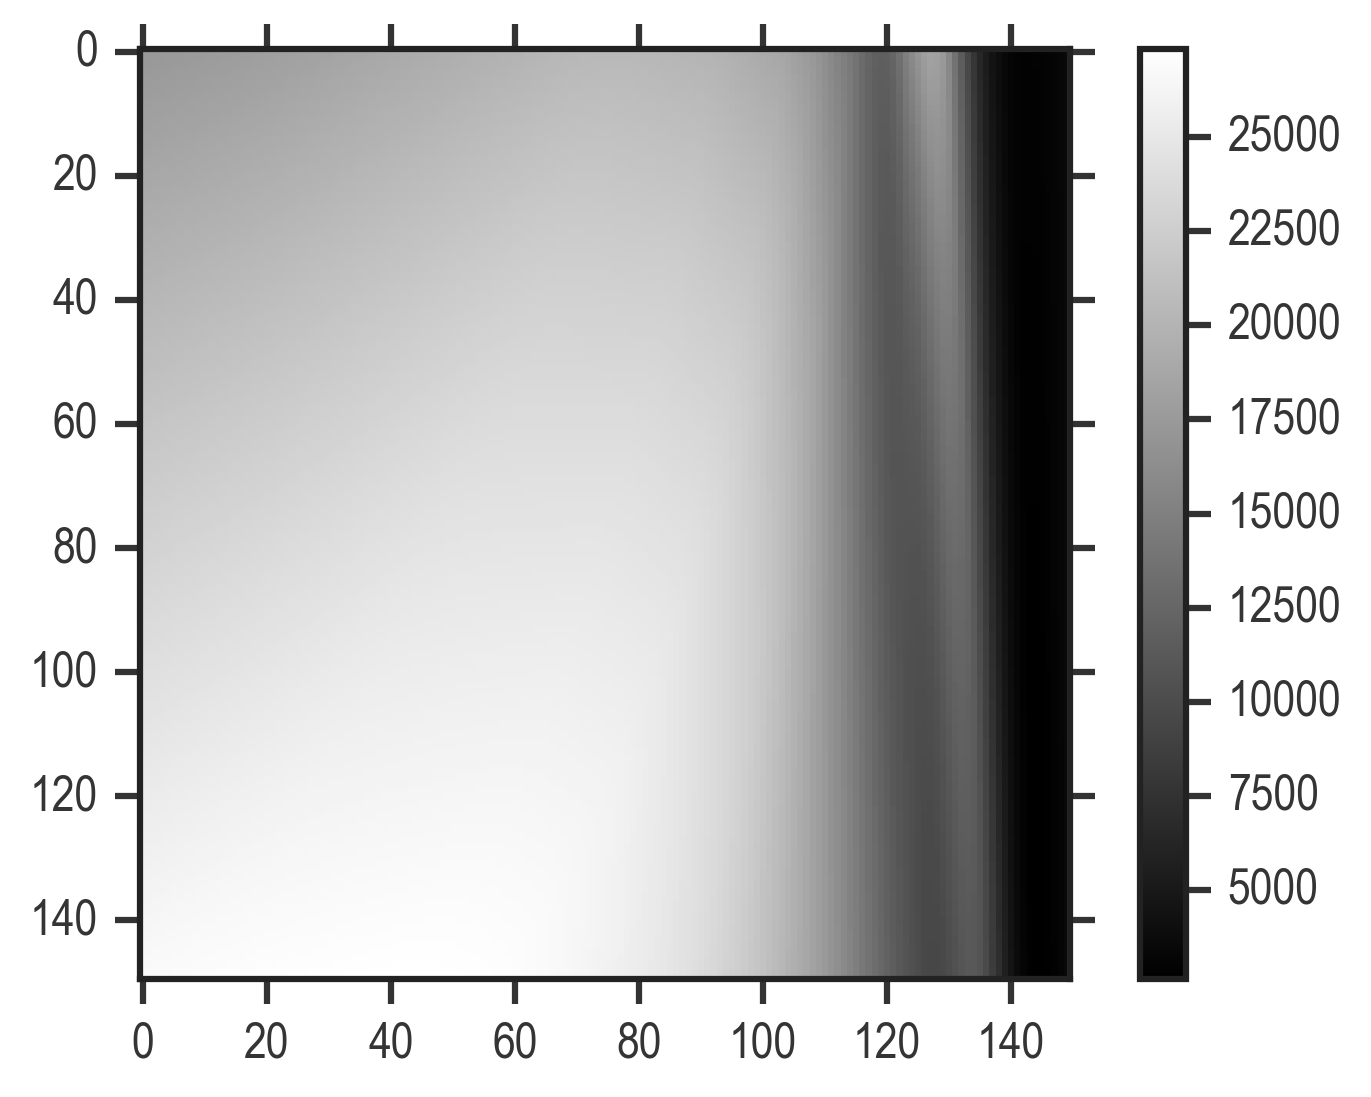

In [114]:
plt.imshow(mse_colormaps_vs_noise_ideal[0.12])
plt.colorbar()

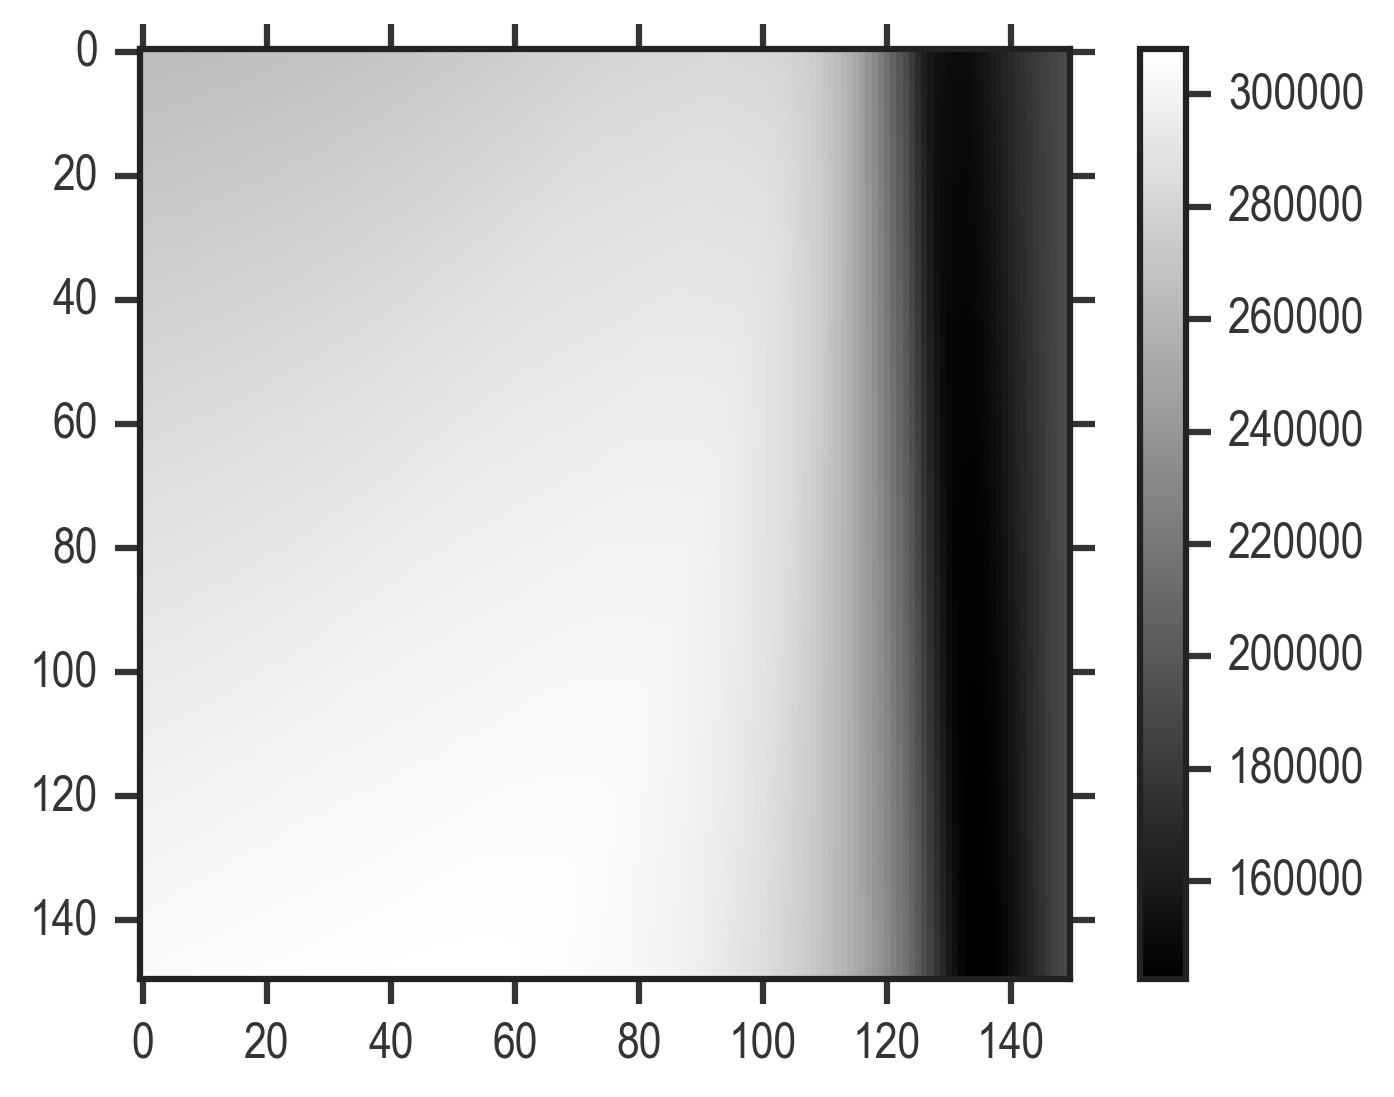

In [115]:
plt.imshow(mse_colormaps_vs_noise_ideal_hr[0.12])
plt.colorbar()